## Project 2
*Alexander Laloi Dybdahl, Viktor Ellevseth, Harald Hobbelhagen*

### Importing libraries

In [1]:
# %pip install numpy==1.25.0
# %pip install --upgrade tensorflow
# %pip install --upgrade keras
# %pip install "numpy<1.25.0"
%pip install --upgrade scipy
%pip install opencv-python-headless
%pip install keras-tuner

import os
import random

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import tensorflow as tf
from PIL import Image, ImageEnhance
from keras import layers, models, optimizers
from skimage.transform import rotate
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/e0/9e/80e2205d138960a49caea391f3710600895dd8292b6868dc9aff7aa593f9/scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.2
    Uninstalling scipy-1.11.2:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'RECORD'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/9d/d7/e2aaf344254292d2046f9984b54212e4e7d69a57d30ae15e7294840710f6/opencv_python_headless-4.8.1.78-cp37-abi3-manylinux_2_17_x86_6

2023-12-18 16:34:51.008562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: U

### Loading and preparing images

In [2]:

def load_image(infilename):
    """
    Load an image from a file.
    
    :param infilename: Path to the image file.
    :return: Image data as a numpy array.
    """
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    """
    Convert an image from floating point to uint8 format.
    
    :param img: Floating point image data.
    :return: Image data in uint8 format.
    """
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    """
    Concatenate an image with its ground truth (label) image.
    
    :param img: Original image as a numpy array.
    :param gt_img: Ground truth image (label image) as a numpy array.
    :return: Concatenated image.
    """
    gt_img = np.squeeze(gt_img)
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    """
    Crop an image into patches of a specified size.
    
    :param im: Image data as a numpy array.
    :param w: Width of each patch.
    :param h: Height of each patch.
    :return: List of image patches.
    """
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

def load_images_from_directory(directory, file_names, max_images=100):
    """
    Load a specified number of images from a directory.

    :param directory: Path to the directory containing images.
    :param file_names: List of file names to load.
    :param max_images: Maximum number of images to load.
    :return: List of loaded images.
    """
    images = [load_image(os.path.join(directory, file_name)) for file_name in file_names[:max_images]]
    return images


### Displaying functions

In [3]:
def make_img_overlay(img, predicted_img):
    """
    Create an overlay image showing the prediction on top of the original image.

    :param img: Original image as a numpy array.
    :param predicted_img: Prediction image as a numpy array (binary mask).
    :return: Image object with overlay.
    """
    # Squeeze the singleton dimension from predicted_img if it exists
    predicted_img = np.squeeze(predicted_img, axis=-1)

    # Get dimensions of the original image
    w, h = img.shape[0], img.shape[1]

    # Create an empty color mask with the same dimensions
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)

    # Set the red channel of the mask to the prediction mask * 255
    color_mask[:, :, 0] = predicted_img * 255

    # Convert the original image to an 8-bit format (0-255 range)
    img8 = img_float_to_uint8(img)

    # Convert numpy arrays to PIL Image objects for blending
    # Convert to RGBA for alpha channel (transparency)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")

    # Blend the original image with the color mask using alpha compositing
    new_img = Image.blend(background, overlay, 0.2)

    return new_img

def display_overlay(test_image, prediction):
    """
    Display the overlay image showing the prediction on top of the test image.

    :param test_image: The test image as a numpy array.
    :param prediction: The prediction mask as a numpy array.
    """
    # Create the overlay image
    overlay_img = make_img_overlay(test_image, prediction)

    # Create a figure and display the overlay image
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_img)
    plt.title('Overlay Image')
    plt.axis('off')  # Turn off the axis
    plt.show()

def display(display_list):
    """
    Display a list of images/masks in a single row.

    :param display_list: List of images/masks to display.
    """
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        image = display_list[i]
        
        # Display the image or mask appropriately based on its dimension
        if image.ndim == 2:  # Grayscale mask
            plt.imshow(image, cmap='gray')
        elif image.ndim == 3 and image.shape[-1] == 1:  # Single-channel mask
            plt.imshow(np.squeeze(image, axis=-1), cmap='gray')
        else:  # RGB Image
            plt.imshow(tf.keras.utils.array_to_img(image))
        
        plt.axis('off')
    plt.show()


### Data augmentation and preproccesing

In [4]:

def elastic_deform(image, alpha, sigma):
    """
    Apply elastic deformation to the image.

    :param image: A numpy array of shape (H, W, C) representing the image.
    :param alpha: The scaling factor for deformation intensity.
    :param sigma: The standard deviation of the Gaussian filter used for smoothing.
    :return: Deformed image as a numpy array.
    """
    assert len(image.shape) == 3, "Image should be HxWxC"

    # Random displacement fields
    dx = scipy.ndimage.gaussian_filter((np.random.rand(*image.shape[:2]) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = scipy.ndimage.gaussian_filter((np.random.rand(*image.shape[:2]) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # Create meshgrid for displacements
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    x, y = np.clip(x + dx, 0, image.shape[1] - 1), np.clip(y + dy, 0, image.shape[0] - 1)

    # Apply displacement
    deformed_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        deformed_image[:, :, i] = scipy.ndimage.map_coordinates(image[:, :, i], [y, x], order=1)

    return deformed_image


In [5]:

def random_crop(img, mask, crop_size):
    """
    Randomly crop an image and its corresponding mask.

    :param img: The image to crop, a numpy array of shape (H, W, C).
    :param mask: The corresponding mask to crop, a numpy array of shape (H, W).
    :param crop_size: The size of the crop (height, width).
    
    :return: Cropped image and mask.
    """
    if (img.shape[0] < crop_size[0]) or (img.shape[1] < crop_size[1]):
        raise ValueError("Crop size must be smaller than image size")

    height, width = img.shape[0], img.shape[1]
    crop_height, crop_width = crop_size

    # Randomly choose the top-left corner of the cropping box
    x = random.randint(0, width - crop_width)
    y = random.randint(0, height - crop_height)

    cropped_img = img[y:y+crop_height, x:x+crop_width, :]
    cropped_mask = mask[y:y+crop_height, x:x+crop_width]

    return cropped_img, cropped_mask

In [6]:

def resize_and_pad(images, masks, new_height, new_width):
    """
    Resize images and masks to new dimensions, maintaining aspect ratio, and add padding if necessary.

    :param images: Numpy array of images.
    :param masks: Numpy array of masks.
    :param new_height: New height after resizing and padding.
    :param new_width: New width after resizing and padding.
    
    :return: Resized and padded images and masks.
    """
    resized_images = np.zeros((len(images), new_height, new_width, images.shape[3]))
    resized_masks = np.zeros((len(masks), new_height, new_width))

    for i, (img, mask) in enumerate(zip(images, masks)):
        # Calculate the aspect ratio and determine dimensions to maintain aspect ratio
        h, w = img.shape[:2]
        scale = min(new_width / w, new_height / h)
        scaled_w, scaled_h = int(w * scale), int(h * scale)

        # Resize image and mask
        resized_img = cv2.resize(img, (scaled_w, scaled_h), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask, (scaled_w, scaled_h), interpolation=cv2.INTER_NEAREST)

        # Calculate padding sizes
        pad_w = (new_width - scaled_w) // 2
        pad_h = (new_height - scaled_h) // 2

        # Pad resized image and mask
        resized_images[i] = np.pad(resized_img, ((pad_h, new_height - scaled_h - pad_h), (pad_w, new_width - scaled_w - pad_w), (0, 0)), mode='constant')
        resized_masks[i] = np.pad(resized_mask, ((pad_h, new_height - scaled_h - pad_h), (pad_w, new_width - scaled_w - pad_w)), mode='constant')

    return resized_images, resized_masks

def pad_to_size(img, target_size):
    """
    Pad an image to a target size.

    :param img: Image to pad.
    :param target_size: Target size as a tuple (height, width).
    :return: Padded image.
    """
    height, width = img.shape[:2]
    pad_height = (target_size[0] - height) // 2
    pad_width = (target_size[1] - width) // 2

    # Calculate padding for even and odd dimensions
    pad_height1, pad_height2 = pad_height, target_size[0] - height - pad_height
    pad_width1, pad_width2 = pad_width, target_size[1] - width - pad_width

    return np.pad(img, ((pad_height1, pad_height2), (pad_width1, pad_width2), (0, 0)), mode='constant')


In [7]:
def color_augmentation(image, enhancement_factors=(0.8, 1.2)):
    """
    Apply random color augmentation to an image.

    :param image: A PIL image.
    :param enhancement_factors: Tuple of min and max factors for augmentation.

    :return: Color-augmented PIL image.
    """
    # Randomly change the brightness, contrast, and saturation
    enhancers = [ImageEnhance.Brightness, ImageEnhance.Contrast, ImageEnhance.Color]
    for enhancer in enhancers:
        factor = random.uniform(*enhancement_factors)
        image = enhancer(image).enhance(factor)

    return image


In [8]:
def scale_variation(images, masks, scale_factors):
    """
    Apply scale variation to images and masks.

    :param images: List or numpy array of images.
    :param masks: List or numpy array of corresponding masks.
    :param scale_factors: Tuple of min and max factors for augmentation.
    
    :return: Augmented images and masks.
    """
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(images, masks):
        # Randomly choose a scale factor
        scale_factor = random.uniform(*scale_factors)

        # Resize image and mask
        scaled_img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
        scaled_mask = cv2.resize(mask, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)

        augmented_images.append(scaled_img)
        augmented_masks.append(scaled_mask)

    return np.array(augmented_images), np.array(augmented_masks)

In [9]:
def shearing(image, angle_x, angle_y):
    """
    Apply random shearing to an image.

    :param image: A PIL image.
    :param shear_range: Tuple of min and max shear angles in degrees.

    :return: Sheared PIL image.
    """
    #angle_x = random.uniform(*shear_range)
    #angle_y = random.uniform(*shear_range)
    #angle_x, angle_y = shear_range

    return image.transform(image.size, Image.AFFINE, (1, angle_x, 0, angle_y, 1, 0), resample=Image.BICUBIC)

In [10]:
def add_noise(image, noise_type, mean, std):
    """
    Add random noise to an image.

    :param image: A PIL image.
    :param noise_type: Type of noise to add.
    :param mean: Mean of the noise distribution.
    :param std: Standard deviation of the noise distribution.

    :return: Noisy PIL image.
    """
    image_array = np.array(image)

    if noise_type == "gaussian":
        # Generate Gaussian noise with the same shape as the image for each channel
        noise = np.random.normal(mean, std, image_array.shape[:-1])
        # Add the noise independently to each channel
        noisy_image_array = image_array + noise[:, :, np.newaxis]
    elif noise_type == "salt_and_pepper":
        # Generate salt-and-pepper noise with the same shape as the image for each channel
        noise = np.random.randint(0, 2, image_array.shape[:-1]) * 255
        # Add the noise independently to each channel
        noisy_image_array = image_array + noise[:, :, np.newaxis]
    else:
        raise ValueError("Invalid noise type")

    # Clip the values to be in the valid range [0, 255]
    noisy_image_array = np.clip(noisy_image_array, 0, 255)

    # Convert the noisy NumPy array back to a PIL image
    noisy_image = Image.fromarray(np.uint8(noisy_image_array))

    return noisy_image

In [11]:
def augment_data(images, masks, augment_options, original_size):
    """
    Apply data augmentation techniques to images and masks.

    :param images: List or numpy array of images.
    :param masks: List or numpy array of corresponding masks.
    :param augment_options: Dictionary with options for different augmentations.
    :param original_size: Original size of the images (height, width).
    
    :return: Augmented images and masks.
    """
    augmented_images = list(images)
    augmented_masks = list(masks)
    #augmented_images = []
    #augmented_masks = []

    # Color Augmentation
    if augment_options.get("color_augmentation"):
        print("Applying color augmentation")
        for img, mask in zip(images, masks):
            pil_img = Image.fromarray((img * 255).astype(np.uint8))
            color_augmented_img = color_augmentation(pil_img)
            augmented_images.append(np.array(color_augmented_img) / 255.0)
            augmented_masks.append(mask)  # No change in masks for color augmentation

    # Rotation
    if augment_options.get("rotation"):
        angles = augment_options["rotation"]["angles"]
        print(f"Applying rotation in {angles} angles")
        for img, mask in zip(images, masks):
            for angle in angles:
                augmented_images.append(rotate(img, angle, preserve_range=True))
                augmented_masks.append(rotate(mask, angle, preserve_range=True))

    # Elastic Deformation
    if augment_options.get("deformation"):
        print("Applying deformation")
        alpha, sigma = augment_options["deformation"]["alpha"], augment_options["deformation"]["sigma"]
        for img, mask in zip(images, masks):
            augmented_images.append(elastic_deform(img, alpha, sigma))
            augmented_masks.append(elastic_deform(mask, alpha, sigma))

    # Random Cropping and Padding
    if augment_options.get("cropping"):
        print("Applying cropping")
        crop_height, crop_width = augment_options["cropping"]["height"], augment_options["cropping"]["width"]
        for img, mask in zip(images, masks):
            cropped_img, cropped_mask = random_crop(img, mask, (crop_height, crop_width))
            padded_img = pad_to_size(cropped_img, original_size)
            padded_mask = pad_to_size(cropped_mask, original_size)
            augmented_images.append(padded_img)
            augmented_masks.append(padded_mask)

    # Flipping
    if augment_options.get("flipping"):
        print("Applying flipping")
        for img, mask in zip(images, masks):
            # Horizontal flip
            augmented_images.append(np.fliplr(img))
            augmented_masks.append(np.fliplr(mask))
            # Vertical flip
            augmented_images.append(np.flipud(img))
            augmented_masks.append(np.flipud(mask))
            
    # Scaling
    if augment_options.get("scaling"):
        print("Applying scaling")
        scale_factors = augment_options["scaling"]["factors"]
        for img, mask in zip(images, masks):
            scaled_img, scaled_mask = scale_variation([img], [mask], scale_factors)
            augmented_images.append(scaled_img)
            augmented_masks.append(scaled_mask)
            
    # Shearing
    if augment_options.get("shearing"):
        print("Applying shearing")
        shear_range = augment_options["shearing"]["range"]
        for img, mask in zip(images, masks):
            angle_x = random.uniform(*shear_range)
            angle_y = random.uniform(*shear_range)
            # Apply shearing to the image
            pil_img = Image.fromarray((img * 255).astype(np.uint8))
            sheared_img = shearing(pil_img, angle_x, angle_y)
            augmented_images.append(np.array(sheared_img) / 255.0)
            
            # Apply shearing to the mask as well
            pil_mask = Image.fromarray((mask[:, :, 0] * 255).astype(np.uint8))
            sheared_mask = shearing(pil_mask, angle_x, angle_y)
            mask_array = np.array(sheared_mask) / 255.0
            augmented_masks.append(np.expand_dims(mask_array, axis=-1))
            
    # Noise
    if augment_options.get("noise"):
        print("Applying noise")
        noise_type = augment_options["noise"]["type"]
        mean, std = augment_options["noise"]["mean"], augment_options["noise"]["std"]
        for img, mask in zip(images, masks):
            pil_img = Image.fromarray((img * 255).astype(np.uint8))
            noisy_img = add_noise(pil_img, noise_type, mean, std)
            augmented_images.append(np.array(noisy_img) / 255.0)
            augmented_masks.append(mask)  # No change in masks for noise
    
    return np.array(augmented_images), np.array(augmented_masks)


### Performing loading

In [12]:
root_dir = "training/"

# Load original images
image_dir = os.path.join(root_dir, "images/")
image_files = os.listdir(image_dir)
n = min(100, len(image_files))
print(f"Loading {n} original images")
imgs = load_images_from_directory(image_dir, image_files, max_images=n)

# Load ground truth images
gt_dir = os.path.join(root_dir, "groundtruth/")
print(f"Loading {n} ground truth images")
gt_imgs = load_images_from_directory(gt_dir, image_files, max_images=n)
gt_imgs = np.expand_dims(gt_imgs, axis=-1)  # Add an extra dimension


Loading 100 original images
Loading 100 ground truth images


### Defining parameters

In [13]:
# Constant parameters
original_height, original_width = 400, 400
test_size = 0.30
random_state = 42
threshold = 0.5

# U-net hyperparameters
activation='relu'
depth = 4
dropout_rate = 0.1
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
patience = 3
batch_size = 10
epochs = 25

### Performing augmentation

In [14]:
# Choose augmentation options
augment_options = {
    "color_augmentation": True
    , "rotation": {"angles": [0, 45, 90, 135, 180, 225, 270, 315]}
    , "deformation": {"alpha": 34, "sigma": 4}
    , "cropping": {"height": 200, "width": 200}
    , "flipping": True,
    #"scaling": {"factors": (0.8, 1.2)},
    "shearing": {"range": (-0.4, 0.4)},
    "noise": {"type": "gaussian", "mean": 0, "std": 0.4}
}

# Split data for validation set
imgs, X_validation, gt_imgs, y_validation = train_test_split(imgs, gt_imgs, test_size=0.10, random_state=42)

X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

# Apply augmentations
augmented_imgs, augmented_gt_imgs = augment_data(imgs, gt_imgs, augment_options, (original_height, original_width))

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(augmented_imgs, augmented_gt_imgs, test_size=0.30, random_state=42)

# Normalization
X_train = X_train.astype('float32') #/ 255
X_test = X_test.astype('float32') #/ 255
X_validation = X_validation.astype('float32') #/ 255

# Make sure that the gt are binary 0 and 1
y_train = (y_train > 0.5).astype(np.float32)
y_test = (y_test > 0.5).astype(np.float32)
y_validation = (y_validation > 0.5).astype(np.float32)


Applying color augmentation
Applying rotation in [0, 45, 90, 135, 180, 225, 270, 315] angles
Applying deformation
Applying cropping
Applying flipping
Applying shearing
Applying noise


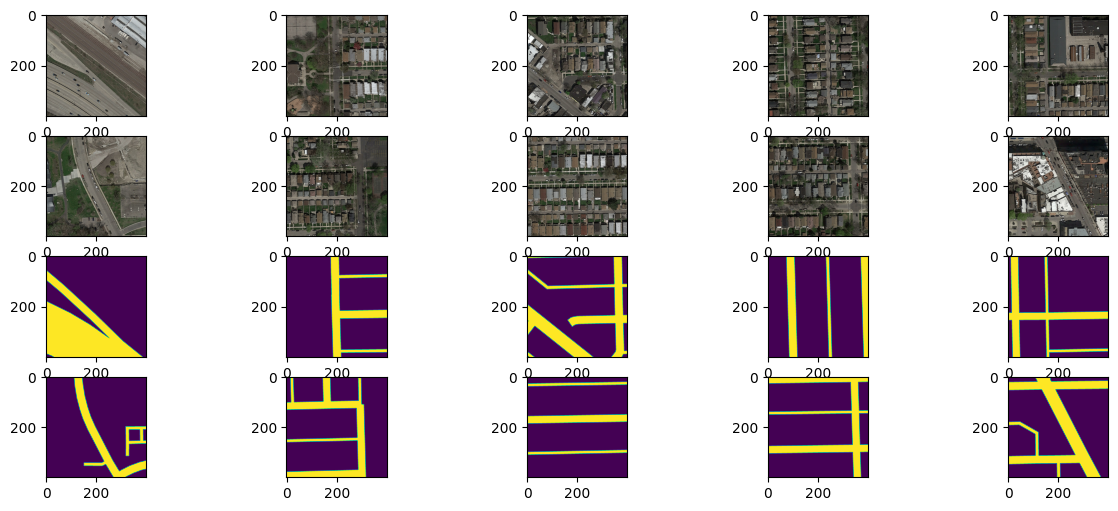

In [15]:
ten_images = augmented_imgs[:10]
ten_train_y = augmented_gt_imgs[:10]

# Create a subplot for each image
fig, axes = plt.subplots(4, 5, figsize=(15, 6))

# Flatten the 2D array of subplots
axes = axes.flatten()

# Loop through the first ten images and display them
for i in range(10):
    axes[i].imshow(ten_images[i])
    axes[i+10].imshow(ten_train_y[i])
    #axes[i].axis('off')

# Adjust layout and display the plot
#plt.tight_layout()
plt.show()

In [16]:
print("Dataset Summary:\n")

print(f"Training Images:\n - Min Value: {X_train.min():.4f}\n - Max Value: {X_train.max():.4f}\n - Shape: {X_train.shape}")
print(f"Test Images:\n - Min Value: {X_test.min():.4f}\n - Max Value: {X_test.max():.4f}\n - Shape: {X_test.shape}")
print(f"Validation Images:\n - Min Value: {X_validation.min():.4f}\n - Max Value: {X_validation.max():.4f}\n - Shape: {X_validation.shape}")

print(f"Training Masks:\n - Min Value: {y_train.min():.4f}\n - Max Value: {y_train.max():.4f}\n - Shape: {y_train.shape}")
print(f"Test Masks:\n - Min Value: {y_test.min():.4f}\n - Max Value: {y_test.max():.4f}\n - Shape: {y_test.shape}")
print(f"Validation Masks:\n - Min Value: {y_validation.min():.4f}\n - Max Value: {y_validation.max():.4f}\n - Shape: {y_validation.shape}")

Dataset Summary:

Training Images:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (1008, 400, 400, 3)
Test Images:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (432, 400, 400, 3)
Validation Images:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (10, 400, 400, 3)
Training Masks:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (1008, 400, 400, 1)
Test Masks:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (432, 400, 400, 1)
Validation Masks:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (10, 400, 400, 1)


### Building U-net

In [18]:
def build_unet(img_height, img_width, img_channels, num_classes, start_filters, depth, dropout_rate, activation='relu'):
    """
    Build a U-Net model with customizable parameters.

    :param img_height: Height of the input images.
    :param img_width: Width of the input images.
    :param img_channels: Number of channels in the input images.
    :param num_classes: Number of output classes.
    :param start_filters: Number of filters in the first layer.
    :param depth: Depth of the U-Net.
    :param dropout_rate: Dropout rate for regularization.
    :param activation: Activation function to use.
    
    :return: A Keras model representing the U-Net.
    """
    inputs = layers.Input((img_height, img_width, img_channels))

    # Contraction path
    contraction_layers = []
    x = inputs
    for i in range(depth):
        x = layers.Conv2D(start_filters * (2 ** i), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(i * dropout_rate)(x)
        x = layers.Conv2D(start_filters * (2 ** i), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        contraction_layers.append(x)
        x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(start_filters * (2 ** depth), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(depth * dropout_rate)(x)
    x = layers.Conv2D(start_filters * (2 ** depth), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)

    # Expansive path
    for i in reversed(range(depth)):
        x = layers.Conv2DTranspose(start_filters * (2 ** i), (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, contraction_layers[i]])
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    return models.Model(inputs=[inputs], outputs=[outputs])

activations = ['relu', 'leaky_relu', 'elu']

# Building u-net
model = build_unet(original_height, original_width, 3, 1, 16, 4, 0.1, activation='relu')  # Customize as needed
model.summary()  # View the model architecture

2023-12-18 12:58:39.648240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 12:58:39.681273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 12:58:39.683275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 400, 400, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [19]:
def build_unet_hp(hp):
    """
    Build a U-Net model with customizable parameters.

    :param img_height: Height of the input images.
    :param img_width: Width of the input images.
    :param img_channels: Number of channels in the input images.
    :param num_classes: Number of output classes.
    :param start_filters: Number of filters in the first layer.
    :param depth: Depth of the U-Net.
    :param dropout_rate: Dropout rate for regularization.
    :param activation: Activation function to use.
    
    :return: A Keras model representing the U-Net.
    """
    img_height = original_height
    img_width  = original_width
    img_channels = 3
    num_classes = 1
    depth = 4
    inputs = layers.Input((img_height, img_width, img_channels))
    
    hp_start_filters = hp.Int('start_filters', min_value=10, max_value=20, step=1)
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.25, step=0.01)
    hp_learning_rate = hp.Float('learning_rate', min_value=0.01, max_value=0.3, step=0.01)

    # Contraction path
    contraction_layers = []
    x = inputs
    for i in range(depth):
        x = layers.Conv2D(hp_start_filters * (2 ** i), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(i * hp_dropout_rate)(x)
        x = layers.Conv2D(hp_start_filters * (2 ** i), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        contraction_layers.append(x)
        x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(hp_start_filters * (2 ** depth), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(depth * hp_dropout_rate)(x)
    x = layers.Conv2D(hp_start_filters * (2 ** depth), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)

    # Expansive path
    for i in reversed(range(depth)):
        x = layers.Conv2DTranspose(hp_start_filters * (2 ** i), (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, contraction_layers[i]])
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=['accuracy'], loss='binary_crossentropy')

    return model

### Plotting model

In [ ]:
# utils.plot_model(model, "model.png")

### Load existing model

In [50]:
# Load the model
model = models.load_model('models/model_0.0312_0.9870_0.1025_0.9703.keras')

### Performing auto tuning

In [20]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(build_unet_hp,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Using TensorFlow backend
Reloading Tuner from my_dir/intro_to_kt/tuner0.json


/tmp/ipykernel_1/3378989002.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [21]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('start_filters')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

print(best_hps.get('start_filters'))
print(best_hps.get('learning_rate'))
print(best_hps.get('dropout_rate'))


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 20 and the optimal learning rate for the optimizer
is 0.14.

20
0.14
0.13


### Performing fitting

In [20]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 400, 400, 20  560         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_5 (Dropout)            (None, 400, 400, 20  0           ['conv2d_11[0][0]']              
                                )                                                           

In [22]:
model = tuner.hypermodel.build(best_hps)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=25, epochs=100, callbacks=callbacks)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100


2023-12-18 12:58:46.739994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-18 12:58:47.959826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


41/41 [==============================] - 52s 944ms/step - loss: 0.4504 - accuracy: 0.8127 - val_loss: 332.4505 - val_accuracy: 0.8215
Epoch 2/100
41/41 [==============================] - 31s 756ms/step - loss: 0.4050 - accuracy: 0.8220 - val_loss: 9.8359 - val_accuracy: 0.8215
Epoch 3/100
41/41 [==============================] - 31s 759ms/step - loss: 0.3558 - accuracy: 0.8304 - val_loss: 1.4645 - val_accuracy: 0.8215
Epoch 4/100
41/41 [==============================] - 31s 757ms/step - loss: 0.3224 - accuracy: 0.8483 - val_loss: 2.3680 - val_accuracy: 0.8215
Epoch 5/100
41/41 [==============================] - 31s 755ms/step - loss: 0.2865 - accuracy: 0.8687 - val_loss: 1.7767 - val_accuracy: 0.8214
Epoch 6/100
41/41 [==============================] - 31s 756ms/step - loss: 0.2628 - accuracy: 0.8836 - val_loss: 1.3558 - val_accuracy: 0.8203
Epoch 7/100
41/41 [==============================] - 31s 756ms/step - loss: 0.2468 - accuracy: 0.8929 - val_loss: 0.8066 - val_accuracy: 0.8432
Ep

In [72]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=35, epochs=100, callbacks=callbacks)

Epoch 1/100


2023-12-18 17:14:09.536031: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 341.80MiB (rounded to 358400000)requested by op model/batch_normalization/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-12-18 17:14:09.536134: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-12-18 17:14:09.536152: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 636, Chunks in use: 635. 159.0KiB allocated for chunks. 158.8KiB in use in bin. 39.0KiB client-requested in use in bin.
2023-12-18 17:14:09.536163: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 86, Chunks in use: 86. 43.8KiB allocated for chunks. 43.8KiB in use in bin. 43.0KiB client-requested in use in bin.
2023-12-18 17

ResourceExhaustedError: Graph execution error:

Detected at node 'model/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1046, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1/4101741680.py", line 4, in <module>
      history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=35, epochs=100, callbacks=callbacks)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 662, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/batch_normalization/FusedBatchNormV3'
OOM when allocating tensor with shape[35,16,400,400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/batch_normalization/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_51352]

In [17]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3

num_classes = 1

inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Contraction path
c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = layers.Dropout(0.1)(c1)
c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = layers.BatchNormalization()(c1)
r1 = layers.ReLU()(b1)
p1 = layers.MaxPooling2D((2, 2))(r1)

c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = layers.Dropout(0.1)(c2)
c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = layers.BatchNormalization()(c2)
r2 = layers.ReLU()(b2)
p2 = layers.MaxPooling2D((2, 2))(r2)
 
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = layers.BatchNormalization()(c3)
r3 = layers.ReLU()(b3)
p3 = layers.MaxPooling2D((2, 2))(r3)
 
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = layers.BatchNormalization()(c4)
r4 = layers.ReLU()(b4)
p4 = layers.MaxPooling2D(pool_size=(2, 2))(r4)

# Bottleneck
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = layers.BatchNormalization()(c5)
r5 = layers.ReLU()(b5)
c5 = layers.Dropout(0.3)(r5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


# Expansive path 
u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
u6 = layers.BatchNormalization()(u6)
u6 = layers.ReLU()(u6)
 
u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = layers.concatenate([u7, c3])
u7 = layers.BatchNormalization()(u7)
u7 = layers.ReLU()(u7)
 
u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = layers.concatenate([u8, c2])
u8 = layers.BatchNormalization()(u8)
u8 = layers.ReLU()(u8)
 
u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = layers.concatenate([u9, c1], axis=3)
u9 = layers.BatchNormalization()(u9)
u9 = layers.ReLU()(u9)

outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=30, epochs=200, callbacks=callbacks)

2023-12-18 16:35:32.573692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 16:35:32.607490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 16:35:32.610308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/200


2023-12-18 16:35:40.405108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-18 16:35:41.903478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-12-18 16:35:46.160384: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2999045c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 16:35:46.160443: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-12-18 16:35:46.166933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-18 16:35:46.338790: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using X

34/34 [==============================] - 49s 922ms/step - loss: 0.5365 - accuracy: 0.7540 - val_loss: 0.5790 - val_accuracy: 0.8214
Epoch 2/200
34/34 [==============================] - 23s 681ms/step - loss: 0.3333 - accuracy: 0.8762 - val_loss: 0.4603 - val_accuracy: 0.8215
Epoch 3/200
34/34 [==============================] - 23s 676ms/step - loss: 0.2508 - accuracy: 0.9102 - val_loss: 0.4587 - val_accuracy: 0.8221
Epoch 4/200
34/34 [==============================] - 23s 674ms/step - loss: 0.2079 - accuracy: 0.9263 - val_loss: 0.4995 - val_accuracy: 0.8220
Epoch 5/200
34/34 [==============================] - 23s 676ms/step - loss: 0.1781 - accuracy: 0.9369 - val_loss: 0.5230 - val_accuracy: 0.8251
Epoch 6/200
34/34 [==============================] - 23s 676ms/step - loss: 0.1580 - accuracy: 0.9429 - val_loss: 0.4631 - val_accuracy: 0.8422
Epoch 7/200
34/34 [==============================] - 23s 677ms/step - loss: 0.1427 - accuracy: 0.9477 - val_loss: 0.4210 - val_accuracy: 0.8572
Epoc

### Saving the fitted model 

In [48]:
# Get the last values from the history
last_loss = history.history['loss'][-1]
last_accuracy = history.history['accuracy'][-1]
last_val_loss = history.history['val_loss'][-1]
last_val_accuracy = history.history['val_accuracy'][-1]

# Save the model
filename = f"models/model_{last_loss:.4f}_{last_accuracy:.4f}_{last_val_loss:.4f}_{last_val_accuracy:.4f}.keras"
model.save(filename)

### Plotting training loss vs validation loss

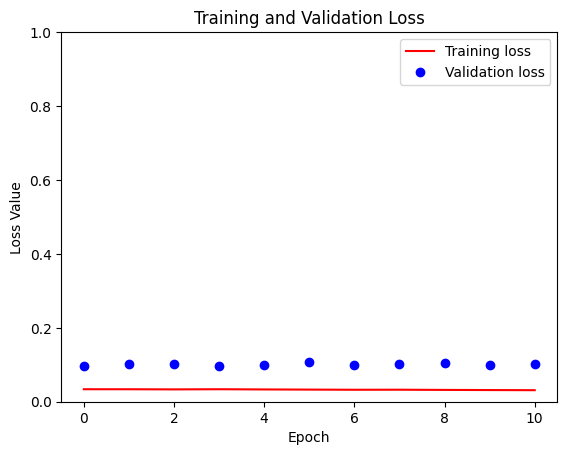

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig("train_validation_loss.png")
plt.show()

### Displaying prediction on test set

In [53]:
def predictions_to_majority_patches(predictions, patch_size=(16, 16)):
    """
    Convert model predictions to majority-voted patches.

    :param predictions: 2D array of predictions.
    :param patch_size: Tuple indicating the size of patches (height, width).
    :return: 2D array where each element represents the majority prediction for a patch.
    """
    height, width = predictions.shape[:2]
    patch_height, patch_width = patch_size
    num_patches_vertically = height // patch_height
    num_patches_horizontally = width // patch_width

    # Initialize an array to store the majority vote for each patch
    majority_patches = np.zeros((num_patches_vertically, num_patches_horizontally), dtype=np.uint8)

    # Iterate over the patches and calculate the majority value
    for i in range(num_patches_vertically):
        for j in range(num_patches_horizontally):
            patch = predictions[i * patch_height: (i + 1) * patch_height, j * patch_width: (j + 1) * patch_width]
            majority_value = np.argmax(np.bincount(patch.flatten()))
            majority_patches[i, j] = majority_value

    return majority_patches

def predictions_to_thresholded_patches(predictions, patch_size=(16, 16), threshold=0.5):
    """
    Convert model predictions to patches based on a threshold.

    :param predictions: 2D array of predictions.
    :param patch_size: Tuple indicating the size of patches (height, width).
    :param threshold: Proportion of foreground pixels required to label a patch as foreground.
    :return: 2D array where each element represents the label for a patch.
    """
    height, width = predictions.shape[:2]
    patch_height, patch_width = patch_size
    num_patches_vertically = height // patch_height
    num_patches_horizontally = width // patch_width

    # Initialize an array to store the label for each patch
    thresholded_patches = np.zeros((num_patches_vertically, num_patches_horizontally), dtype=np.uint8)

    # Iterate over the patches and calculate the label based on the threshold
    for i in range(num_patches_vertically):
        for j in range(num_patches_horizontally):
            patch = predictions[i * patch_height: (i + 1) * patch_height, j * patch_width: (j + 1) * patch_width]
            foreground_proportion = np.mean(patch)
            thresholded_patches[i, j] = int(foreground_proportion > threshold)

    return thresholded_patches


1/1 [==============================] - 0s 299ms/step


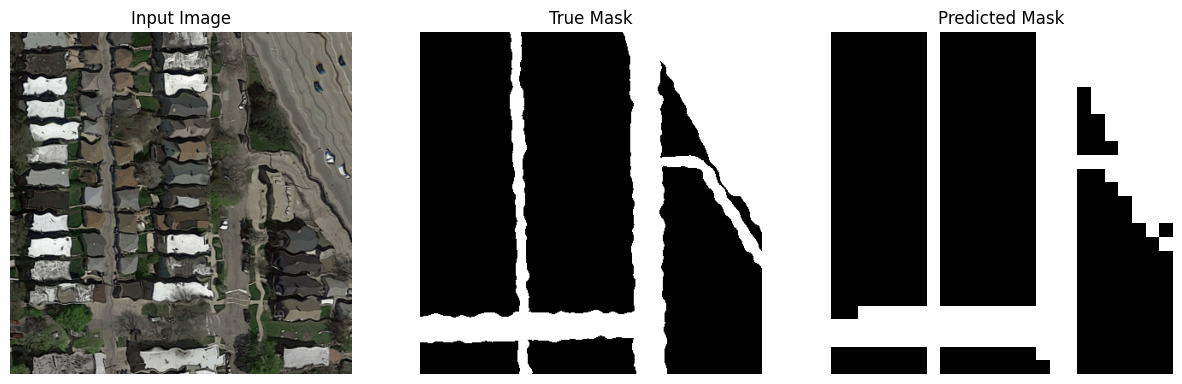

In [54]:
# Displaying arbitrary image
i = random.randint(0, len(X_test) - 1)
sample_image = X_test[i]
sample_mask = y_test[i]

# Predict the mask for the sample image
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)

# Convert the predicted mask into patches
predicted_majority_patches = predictions_to_thresholded_patches(predicted_mask, threshold=0.25)

# Display the original image, true mask, and predicted mask
display([sample_image, sample_mask, predicted_majority_patches])

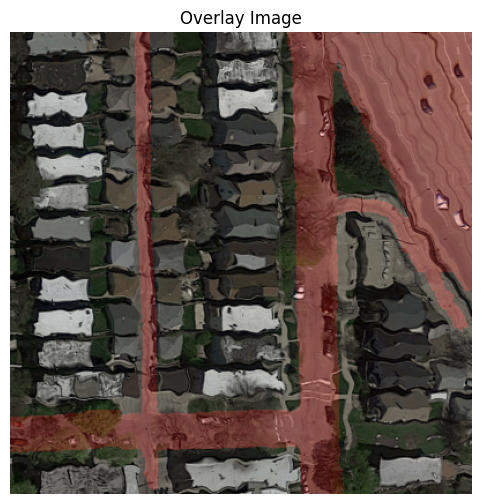

In [55]:
display_overlay(sample_image, predicted_mask)

### Parameter tuning for threshold for predicting patches

In [56]:
def evaluate_thresholds_batch(X_test, y_test, model, thresholds, batch_size=32):
    """
    Evaluate different thresholds for converting model predictions to binary masks using batch processing.

    :param X_test: Test set images.
    :param y_test: True masks for the test set.
    :param model: Trained model for making predictions.
    :param thresholds: List of thresholds to evaluate.
    :param batch_size: Batch size for processing predictions.
    :return: Dictionary with F1 scores for each threshold.
    """
    f1_scores = {threshold: 0 for threshold in thresholds}
    num_batches = len(X_test) // batch_size + (1 if len(X_test) % batch_size else 0)

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch_x = X_test[start_idx:end_idx]
        batch_y = y_test[start_idx:end_idx]

        # Predict for current batch
        batch_pred = model.predict(batch_x)
        batch_y_flat = batch_y.reshape(-1)
        
        for threshold in thresholds:
            # Apply threshold
            batch_pred_flat = (batch_pred > threshold).astype(np.uint8).reshape(-1)

            # Update F1 score calculation
            f1_scores[threshold] += f1_score(batch_y_flat, batch_pred_flat) * len(batch_x)

    # Average F1 scores over all batches
    f1_scores = {threshold: score / len(X_test) for threshold, score in f1_scores.items()}
    return f1_scores

# Example usage
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores = evaluate_thresholds_batch(X_validation, y_validation, model, thresholds)
for threshold, score in f1_scores.items():
    print(f"Threshold: {threshold}, F1 Score: {score:.4f}")

1/1 [==============================] - 0s 40ms/step
Threshold: 0.3, F1 Score: 0.8499
Threshold: 0.4, F1 Score: 0.8497
Threshold: 0.5, F1 Score: 0.8483
Threshold: 0.6, F1 Score: 0.8463
Threshold: 0.7, F1 Score: 0.8432
Threshold: 0.8, F1 Score: 0.8384
Threshold: 0.9, F1 Score: 0.8273


In [57]:
def evaluate_thresholds(X_test, y_test, model, thresholds):
    """
    Evaluate different thresholds for converting model predictions to binary masks using batch processing.

    :param X_test: Test set images.
    :param y_test: True masks for the test set.
    :param model: Trained model for making predictions.
    :param thresholds: List of thresholds to evaluate.
    :return: Dictionary with F1 scores for each threshold.
    """
    f1_scores = {}

    # Predict for all images at once
    predictions = model.predict(X_test)  # Assuming X_test is a numpy array
    predictions_flat = predictions.reshape(-1, predictions.shape[-1])  # Flatten predictions

    # Flatten all true masks
    y_test_flat = y_test.reshape(-1, y_test.shape[-1]).flatten()

    for threshold in thresholds:
        # Apply threshold to all predictions
        predicted_masks_flat = (predictions_flat > threshold).astype(np.uint8)

        # Compute F1 score
        f1 = f1_score(y_test_flat, predicted_masks_flat)
        f1_scores[threshold] = f1

    return f1_scores

# Performing parameter tuning
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores = evaluate_thresholds(X_validation, y_validation, model, thresholds)
for threshold, score in f1_scores.items():
    print(f"Threshold: {threshold}, F1 Score: {score:.4f}")

1/1 [==============================] - 0s 37ms/step
Threshold: 0.3, F1 Score: 0.8499
Threshold: 0.4, F1 Score: 0.8497
Threshold: 0.5, F1 Score: 0.8483
Threshold: 0.6, F1 Score: 0.8463
Threshold: 0.7, F1 Score: 0.8432
Threshold: 0.8, F1 Score: 0.8384
Threshold: 0.9, F1 Score: 0.8273


### Loading test set images and predict

In [58]:
def load_images_from_subfolders(root_dir, n=50):
    """
    Load images from subfolders within a specified directory.

    :param root_dir: Root directory containing image subfolders.
    :param n: Number of subfolders to process.
    :return: List of loaded images.
    """
    imgs = []

    for i in range(1, n + 1):
        subfolder_name = f"test_{i}"
        image_dir = os.path.join(root_dir, subfolder_name)
        
        if os.path.isdir(image_dir):
            files = os.listdir(image_dir)
            if files:
                image_path = os.path.join(image_dir, files[0])
                image = load_image(image_path)
                imgs.append(image)

    return np.array(imgs)

# Loading images
test_root_dir = "test_set_images"
test_images = load_images_from_subfolders(test_root_dir, n=50)


In [59]:
def predict_images(model, images, threshold=0.5):
    """
    Predict each image using the provided model.

    :param model: Trained model for making predictions.
    :param images: Numpy array of images to predict.
    :param threshold: Threshold to convert predictions to binary format.
    :return: Binary predictions for each image as a numpy array.
    """
    predictions = []

    for image in images:
        prediction = model.predict(image[tf.newaxis, ...])[0]
        predicted_mask = (prediction > threshold).astype(np.uint8)
        predictions.append(predicted_mask)

    return np.array(predictions)

# Predicting images
predictions = predict_images(model, test_images)

1/1 [==============================] - 0s 28ms/step


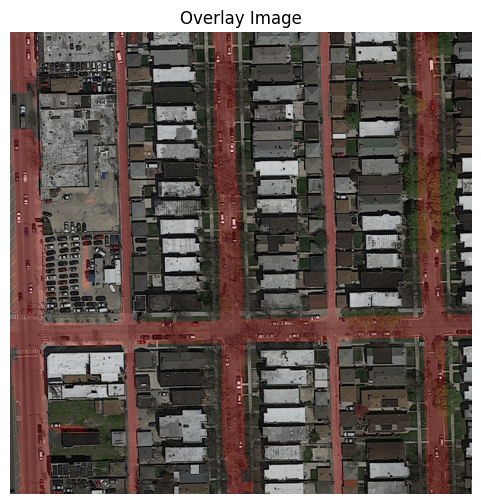

In [71]:
# Displaying arbitrary image
i = random.randint(0, len(test_images) - 1)
display_overlay(test_images[i], predictions[i])

### Creating submission csv

In [73]:
def create_submission_entries(predictions, patch_size=16, threshold=0.25):
    """
    Create submission entries from predicted images.

    :param predictions: Numpy array of predicted images.
    :param patch_size: Size of the patches to be used for submission entries.
    :param threshold: Threshold for deciding the label of a patch.
    :return: DataFrame containing submission entries.
    """
    submission_entries = []

    for img_index in range(predictions.shape[0]):
        image = predictions[img_index, :, :, 0]  # Squeeze out the last dimension for single-channel images
        for j in range(0, image.shape[1], patch_size):  # Iterate columns
            for i in range(0, image.shape[0], patch_size):  # Iterate rows
                patch = image[i:i + patch_size, j:j + patch_size]
                label = 1 if np.mean(patch) > threshold else 0
                submission_entries.append([f"{img_index+1:03d}_{j}_{i}", label])

    return pd.DataFrame(submission_entries, columns=['id', 'prediction'])

def save_submission_to_csv(submission_df, filename):
    """
    Save the submission DataFrame to a CSV file.

    :param submission_df: DataFrame containing submission entries.
    :param filename: Name of the CSV file to save.
    """
    submission_df.to_csv(filename, index=False)

# Saving to submission file
submission_df = create_submission_entries(predictions, threshold=0.4)
save_submission_to_csv(submission_df, 'submissions/sample_submission_0.4_v3.csv')